<a href="https://www.kaggle.com/code/lorresprz/brain-tumor-detection-custom-cnn-pytorch-98-acc?scriptVersionId=163072071" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.utils import shuffle
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cpu


# Plot some images of the brain MRI scans

In [4]:
import cv2

data_path = "../input/brain-mri-images-for-brain-tumor-detection"
#list of images with no tumors
Negative = os.listdir(data_path + '/no/')
#list of image with tumors
Positive = os.listdir(data_path + '/yes/')
print(f'There are {len(Negative)} MRI scans of brains with no tumor')
print(f'There are {len(Positive)} MRI scans of brains with tumor')
      

There are 98 MRI scans of brains with no tumor
There are 155 MRI scans of brains with tumor


In [5]:
#Check the size of some images: all random sizes (which requires reshaping later)
rnd = [0, 10, 7, 8, 153]
for i in range(len(rnd)):
    img0 = cv2.imread(data_path + '/yes/'+ Positive[rnd[i]])
    print(img0.shape)

(298, 260, 3)
(586, 467, 3)
(349, 292, 3)
(993, 825, 3)
(337, 293, 3)


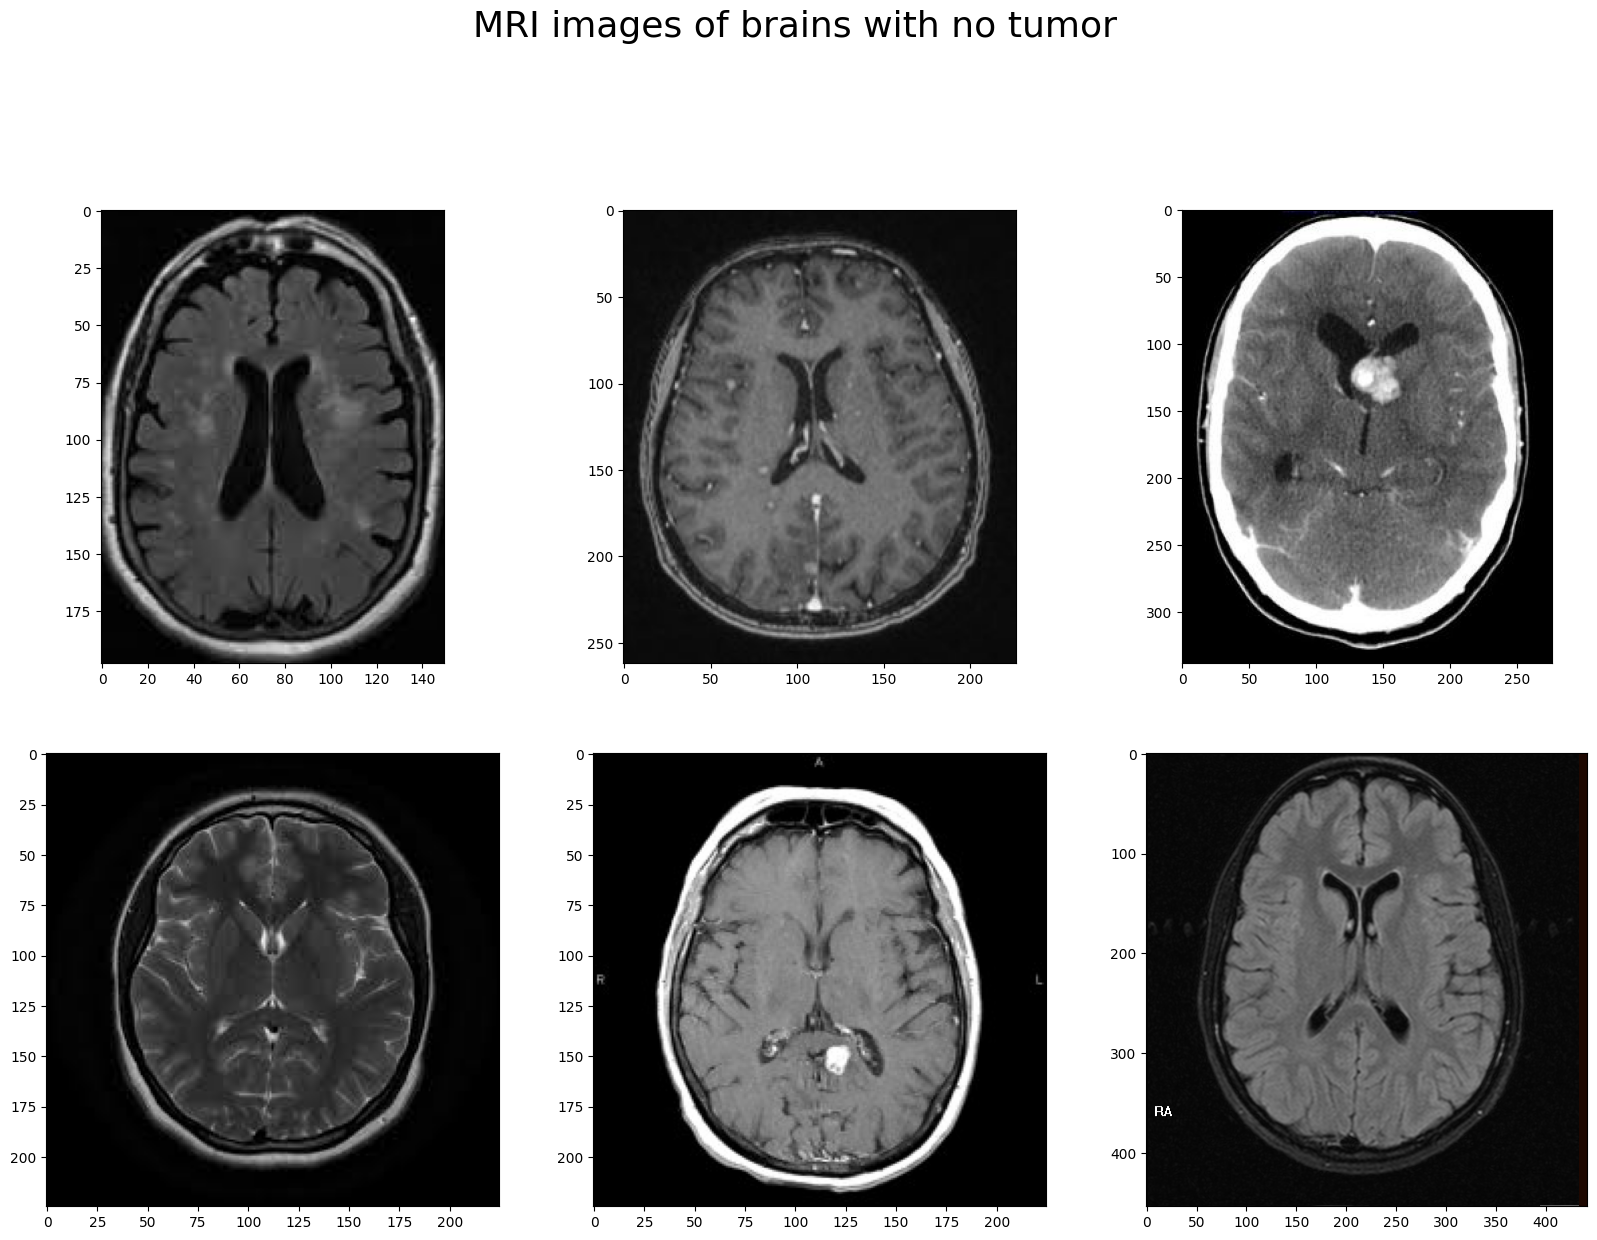

In [6]:
#plot some images of brain MRI with no tumor
fig = plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(data_path+'/no/'+ Negative[i])
    plt.imshow(img)
plt.suptitle("MRI images of brains with no tumor",fontsize=26)
plt.show()

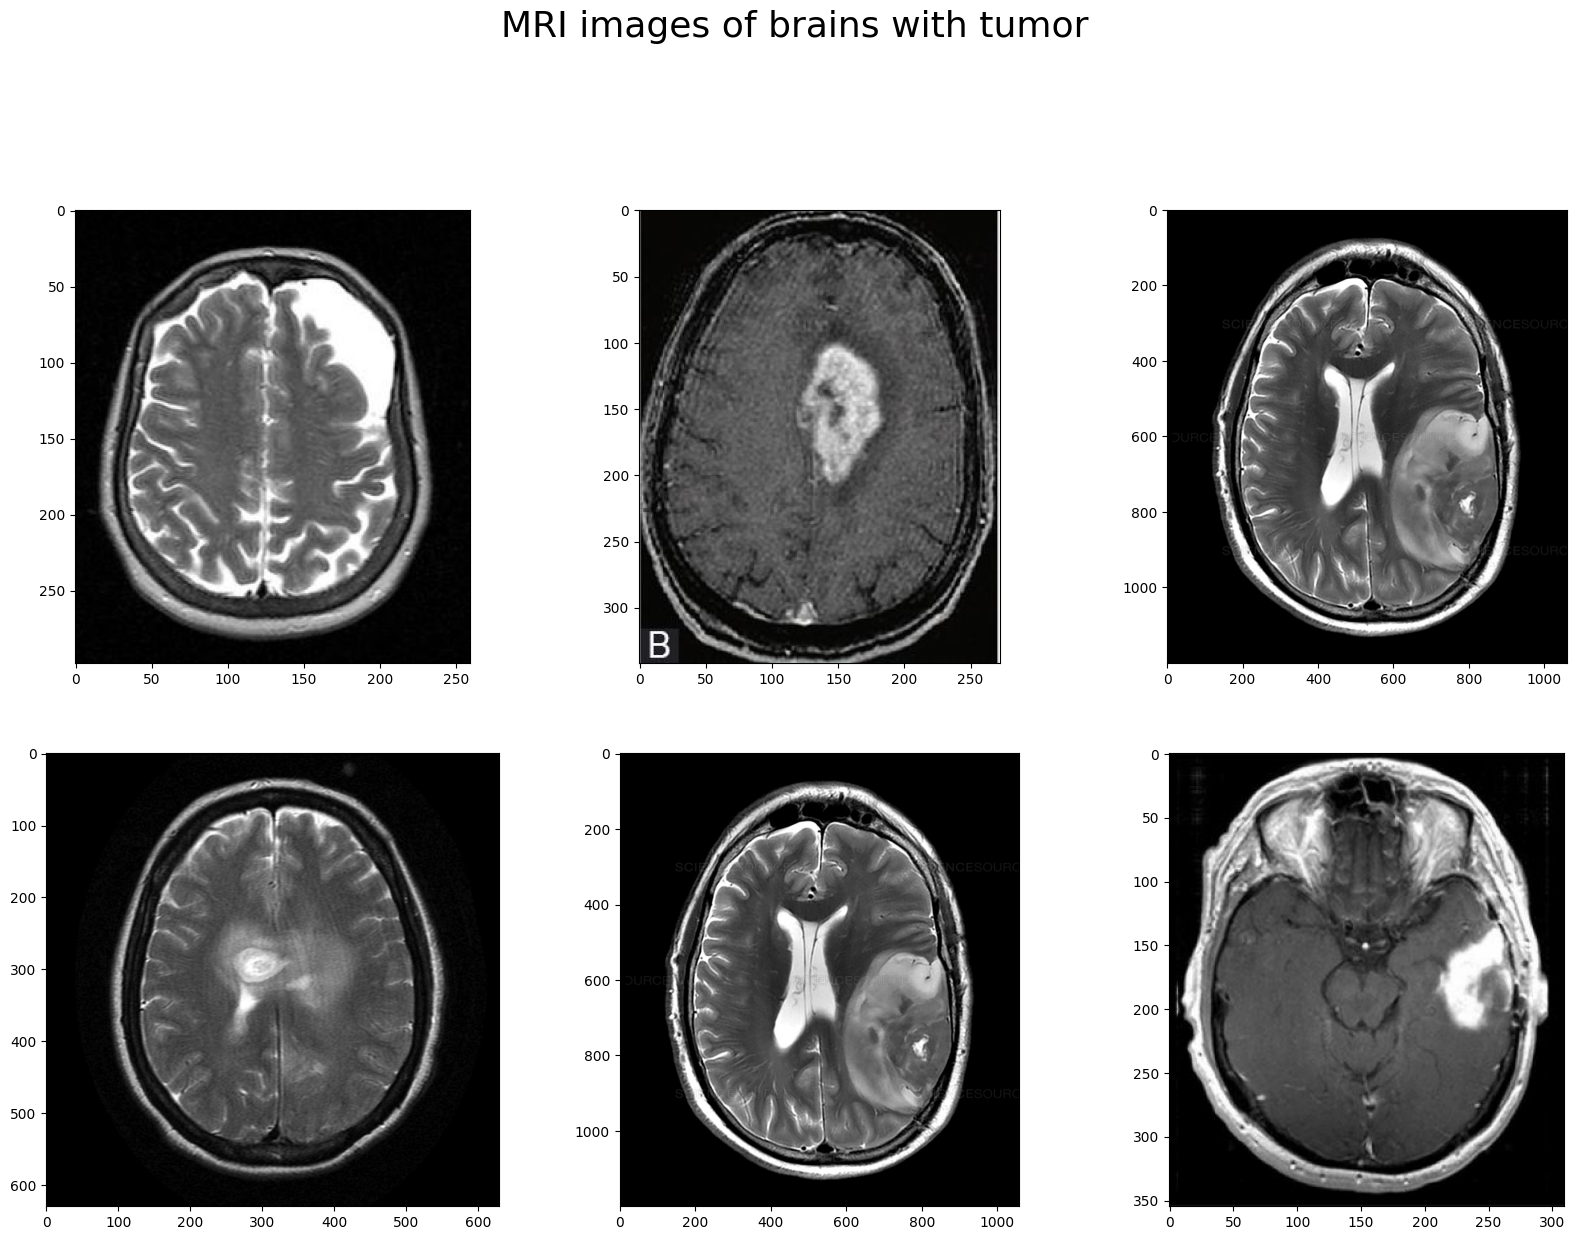

In [7]:
#plot some images of brain MRI with tumor
fig = plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(data_path+'/yes/'+ Positive[i])
    plt.imshow(img)
plt.suptitle("MRI images of brains with tumor",fontsize=26)
plt.show()

# Data processing 

For some reference on how to create a custom dataset:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

The custom dataset class below is from

https://www.kaggle.com/code/tusharcode/brain-tumor-pytorch-model-cnn-and-autoencoders/notebook

with a minor modification (no autoencoder)


In [8]:
from glob import glob
class BrainMRI(Dataset):
    
    def __init__(self,data_dir,reshape=True,height=128,width=128):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        
        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)
    
    def __getitem__(self,idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
            array = array.reshape(self.height,self.width)         
            image_array.append(array)
        
        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):
        return str(self.dataframe.head(10))

In [9]:
df = BrainMRI(data_path)
df

                                               image  labels
0  ../input/brain-mri-images-for-brain-tumor-dete...       0
1  ../input/brain-mri-images-for-brain-tumor-dete...       1
2  ../input/brain-mri-images-for-brain-tumor-dete...       1
3  ../input/brain-mri-images-for-brain-tumor-dete...       1
4  ../input/brain-mri-images-for-brain-tumor-dete...       1
5  ../input/brain-mri-images-for-brain-tumor-dete...       0
6  ../input/brain-mri-images-for-brain-tumor-dete...       1
7  ../input/brain-mri-images-for-brain-tumor-dete...       1
8  ../input/brain-mri-images-for-brain-tumor-dete...       1
9  ../input/brain-mri-images-for-brain-tumor-dete...       0

In [10]:
#quick check of the format of the dataset
img_train, target = df[0]
img_train.shape, img_train, target.shape, target

(torch.Size([1, 128, 128]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 torch.Size([]),
 tensor(0))

# CNN model

This model is a custom model finalized by trial and error. 

In [11]:
class CNN_BrainMRI(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32, 3, 1)
        self.conv2 = nn.Conv2d(32,16, 2, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool
        )
        #Why 15376? See the shape-tracing section below
        self.linear1 = nn.Linear(15376,64)
        self.linear2 = nn.Linear(64,2)

    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        return F.log_softmax(x, dim=1)

In [12]:
model1 = CNN_BrainMRI()
model1.to(device)

CNN_BrainMRI(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=15376, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)

In [13]:
#count the number of parameters in the model
params = [p.numel() for p in model1.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

     288
      32
    2048
      16
  984064
      64
     128
       2
________
  986642


# Trace the shape of the image through the network

For the purpose of record-keeping, I trace the shape of a single input image as it passes through the network  

In [14]:
X = df[0][0]
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,1,128,128)
print(f'The new size is {X.shape}\n')

X = model1.conv_total(X.float())
print(f'Shape of the image after passing through the whole convolution block: \n {X.shape}\n')

X = model1.flat(X.float())
print(f'Shape of the image after passing through the {model1.flat}: \n {X.shape}\n')

X = model1.linear1(X.float())
print(f'Shape of the image after passing through the {model1.linear1}: \n {X.shape}\n')

X = model1.linear2(X.float())
print(f'Shape of the image after passing through the {model1.linear2}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([1, 128, 128])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 128, 128])

Shape of the image after passing through the whole convolution block: 
 torch.Size([1, 16, 31, 31])

Shape of the image after passing through the Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 15376])

Shape of the image after passing through the Linear(in_features=15376, out_features=64, bias=True): 
 torch.Size([1, 64])

Shape of the image after passing through the Linear(in_features=64, out_features=2, bias=True): 
 torch.Size([1, 2])



# Model training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

In [16]:
epochs = 16
batch_size = 32
loss_list = []
correct_list = []
for epoch in range(epochs):
    total_loss = 0
    trn_corr = 0
    for n in range(len(df)//batch_size):    
        data,target = df[n*batch_size:(n+1)*batch_size]
        data = data.view(batch_size,1,128,128)
        #Perform the prediction
        ypred = model1(data.float())
        loss = criterion(ypred,target)
        total_loss +=loss
        #Tally the number of correct predictions
        y_pred_val = torch.max(ypred.data, 1)[1]
        batch_corr = (y_pred_val == target).sum()
        trn_corr += batch_corr
        #Training steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss)
    correct_list.append(trn_corr)
    if epoch%4 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 43.35939025878906
Epochs: 4 Loss: 0.5295284390449524
Epochs: 8 Loss: 0.2321857064962387
Epochs: 12 Loss: 0.04346835985779762


In [17]:
#save the trained model
torch.save(model1.state_dict(), 'CNN_BrainMRI_tumor_classification.pt')

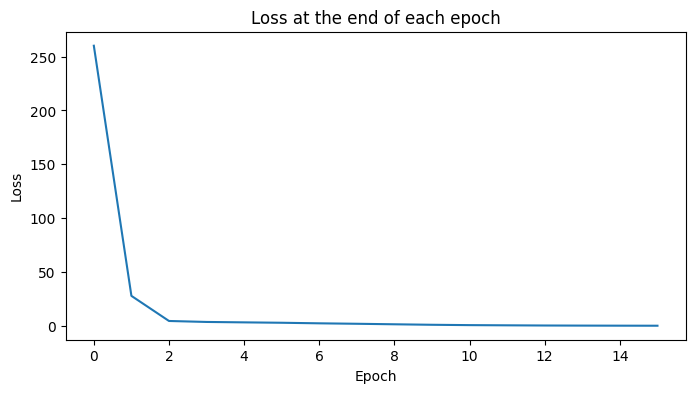

In [18]:
#get rid of the 'requires_grad' in the entries of loss_list
for i in range(len(loss_list)):
    loss_list[i] = loss_list[i].detach().numpy()
#plotting the loss per epoch
fig = plt.figure(figsize=(8,4))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss at the end of each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 'Evaluate' model

Since I didn't do a train test split, the evaluation of the model is not strictly correct in the sense that the trained model should be evaluated on the unseen test data, however, using standard metrics like `accuracy_score` and `confusion_matrix`, the obtained results are quite good: 98% accuracy and very few 'confused' predictions. 

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
preds = []
targets = []

for i in range(len(df)):
    data,target = df[i]
    data = data.view(1,1,128,128)
    pred = model1(data.float())
    pred = torch.argmax(pred,dim=1)
    
    preds.append(pred)
    targets.append(target)
   
acc = accuracy_score(targets, preds)
print(f'The model accuracy is {acc}')

The model accuracy is 0.9841897233201581


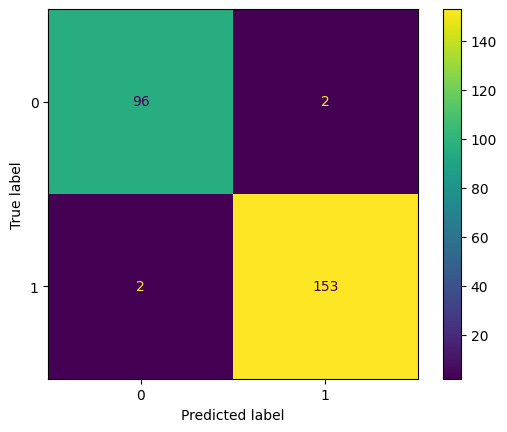

In [20]:
cm =confusion_matrix(targets, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

For demonstration purpose, several images with their true and predicted labels are shown below

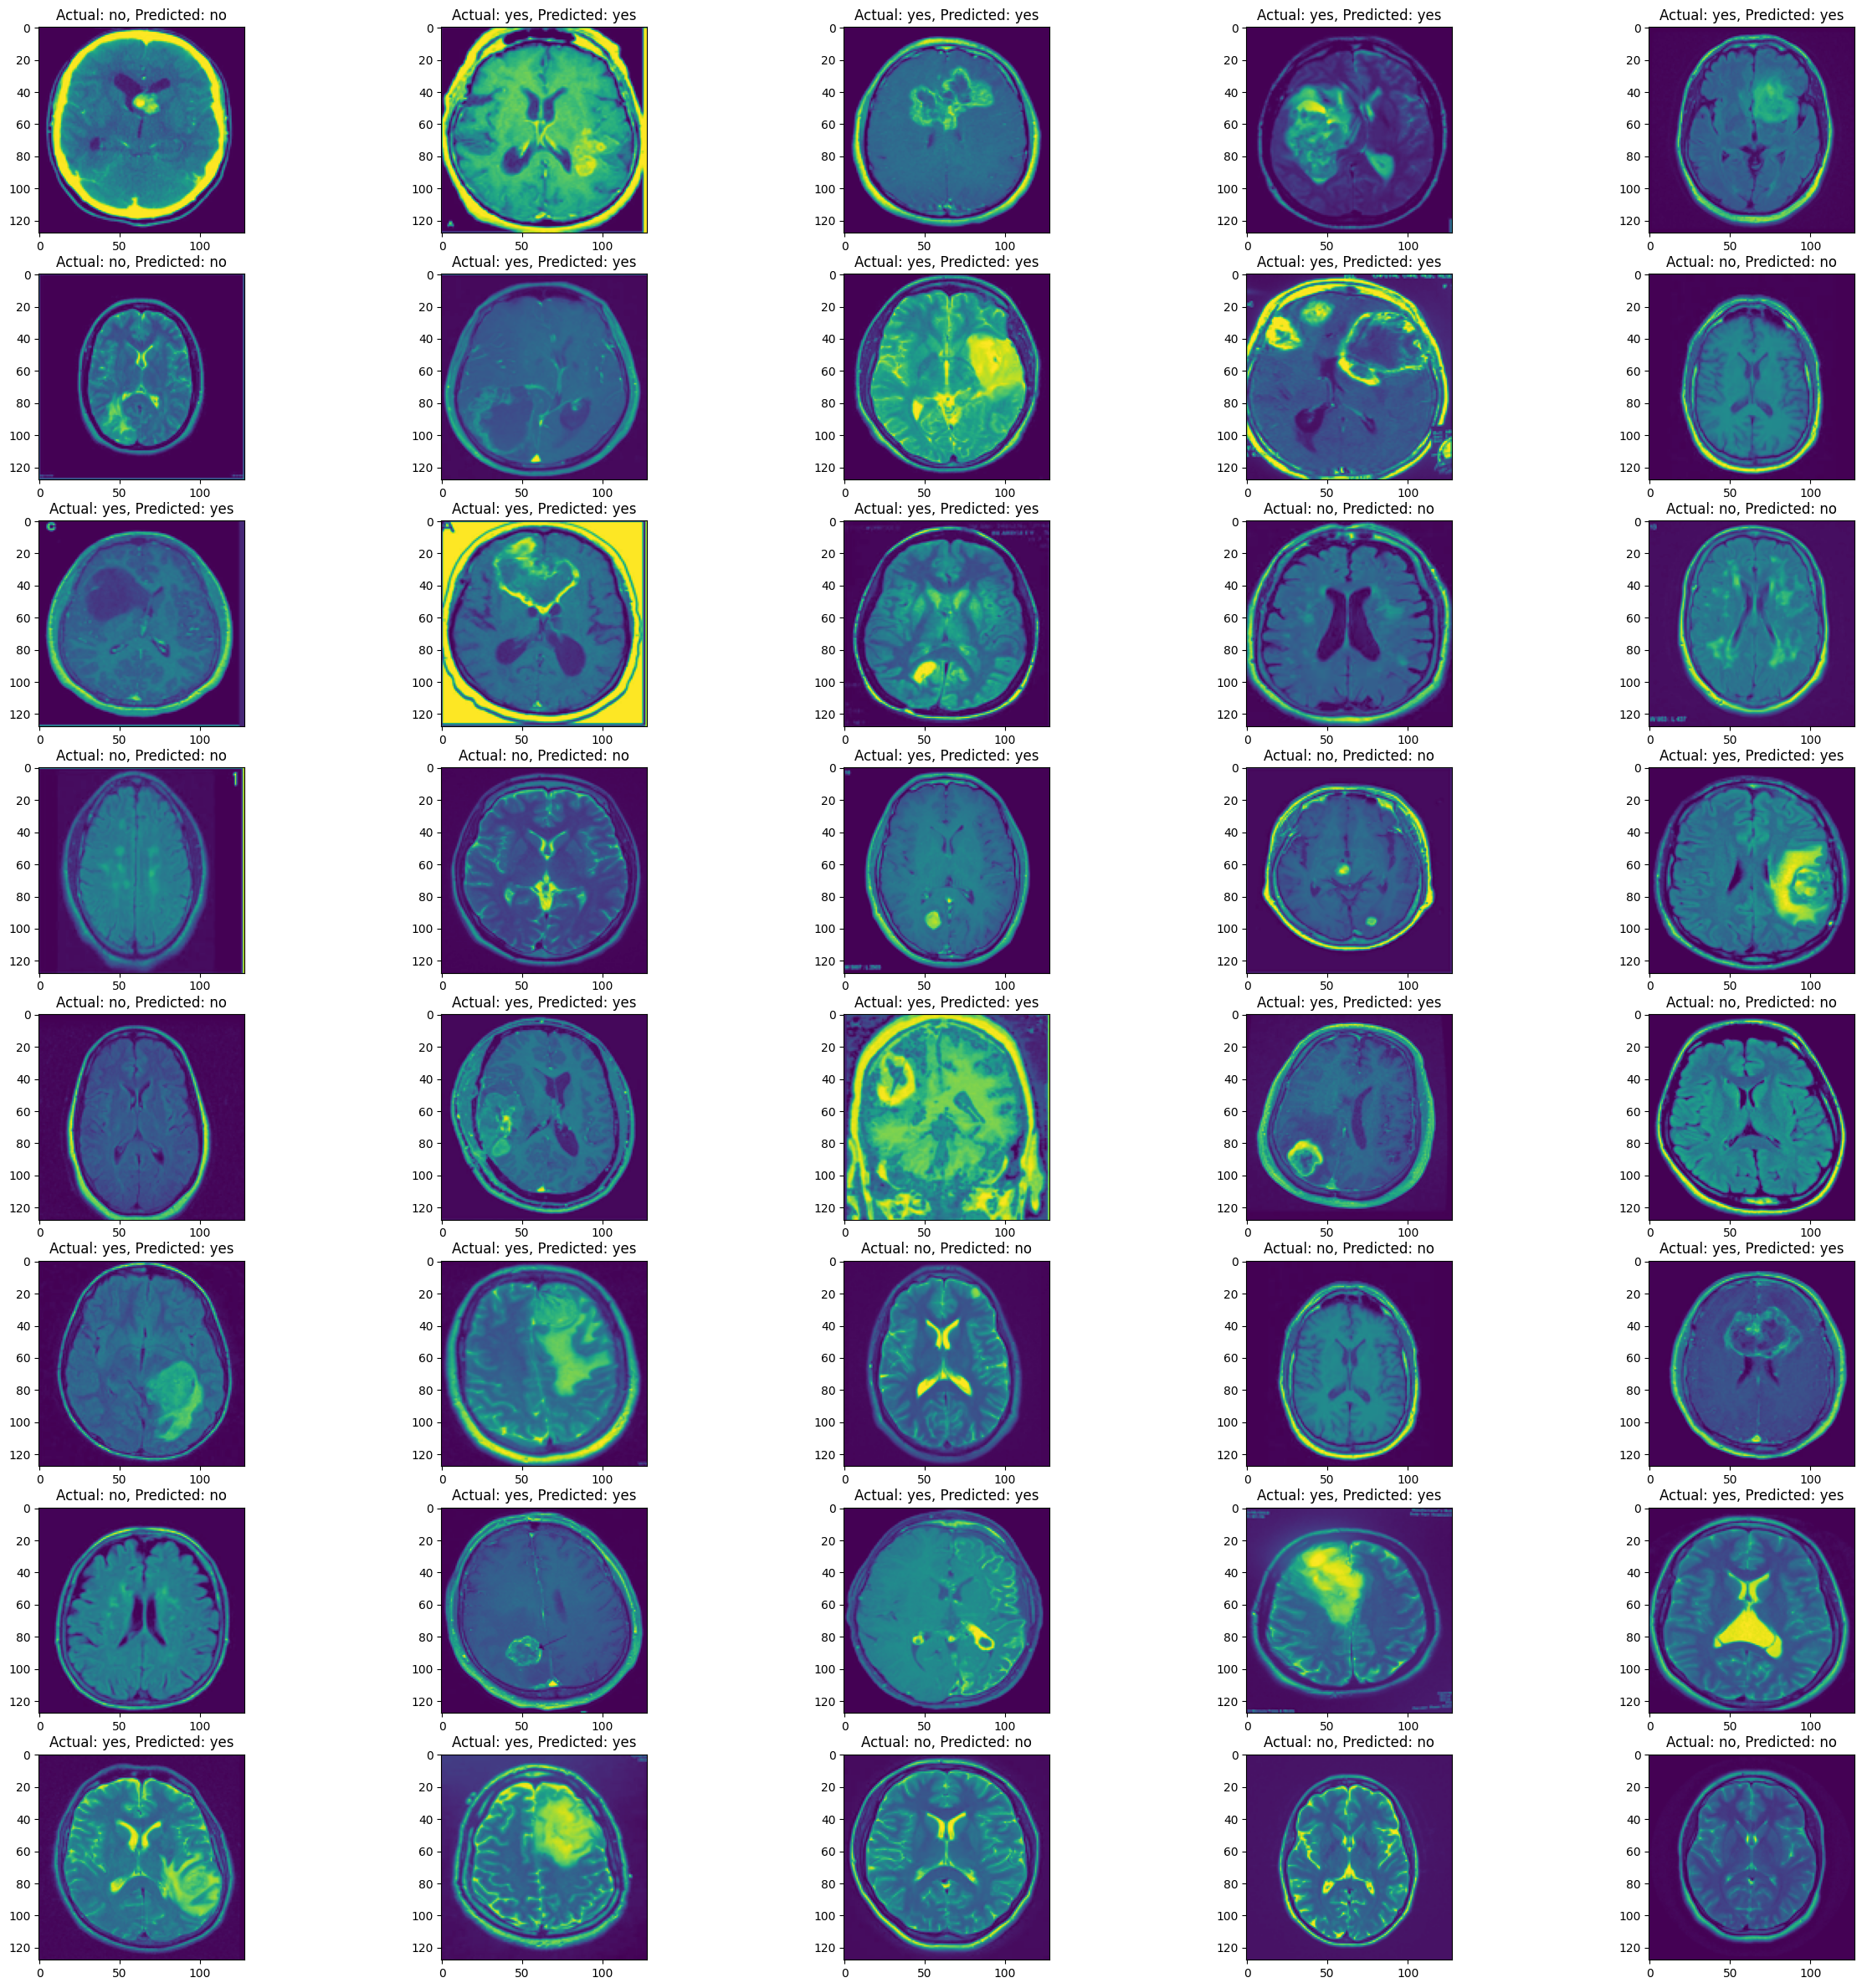

In [21]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(30,30))
for i in range(40):
    data,target = df[i]
    data = data.view(1,1,128,128)
    pred = model1(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(8,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]}, Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()